# FINESST Plots

1. Figure 1 with just the longwave panels.  

2. AIRS Spectral OLR trends with temperature trends in the sidebar.

## 1. Figure 1 with just the longwave panels.  

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [5]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [6]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [7]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [8]:
giss1.close()

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [3]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [4]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [9]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [10]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [11]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES OLR

In [12]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [13]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)

#### Temperature from GISStemp

In [14]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [15]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

### Plot summary data

#### Wrap data for better visualization

In [16]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_statsig_wrapped = xr.concat([gisstemp_statsig,gisstemp_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.97, 'Observed Trends')

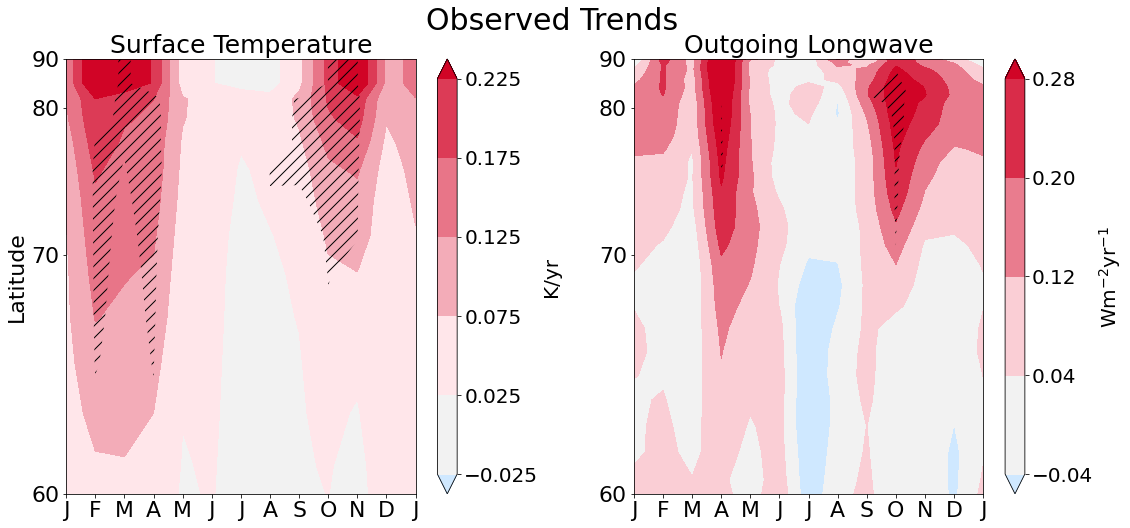

In [22]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

fig1,axs = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
fig1.subplots_adjust(wspace=0.3,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(gisstemp_trends_wrapped['month'],lat_weighted0,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im0.cmap.set_under((0.81,0.91,1.00))
stip = axes[0].contourf(gisstemp_statsig_wrapped['month'],lat_weighted0,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Surface Temperature',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='K/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*olr_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(olr_trends_wrapped['month'],lat_weighted1,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im1.cmap.set_under((0.81,0.91,1.00))
stip = axes[1].contourf(olr_statsig_wrapped['month'],lat_weighted1,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Outgoing Longwave',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Observed Trends',fontsize=30,y=0.97)

In [23]:
to_png(fig1,'observedtLWrends_2panel')

## 2. AIRS Spectral OLR trends with temperature trends in the sidebar.

#### Load pre-calculated AIRS trends (lon. averaged)

In [25]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))    

In [36]:
all_data_spec_olr_wgtd = add_weights(all_data_spec_olr['TREND'])
all_data_spec_olr_clr_wgtd = add_weights(all_data_spec_olr_clr['TREND'])

all_data_spec_olr.close()
all_data_spec_olr_clr.close()

olr_trend_spatavg = masked_average(all_data_spec_olr_wgtd,dim=['lat'],weights=all_data_spec_olr_wgtd['cell_weight'])
olr_clr_trend_spatavg = masked_average(all_data_spec_olr_clr_wgtd,dim=['lat'],weights=all_data_spec_olr_clr_wgtd['cell_weight'])

### Nice plot for OLR

In [103]:
gisstemp_AIRSsubset = giss_tsel.sel(lat=slice(None,59),time=slice('2003-01-01','2018-12-31'))

gisstemp_AIRStrends,gisstemp_AIRSstatsig,gisstemp_AIRSnotnull = compute_trends_n_signif2(gisstemp_AIRSsubset)
gisstemp_AIRStrends_wgtd = add_weights(gisstemp_AIRStrends)
gisstemp_AIRStrends_spatavg = masked_average(gisstemp_AIRStrends_wgtd,weights=gisstemp_AIRStrends_wgtd['cell_weight'],dim=['lat','lon'])

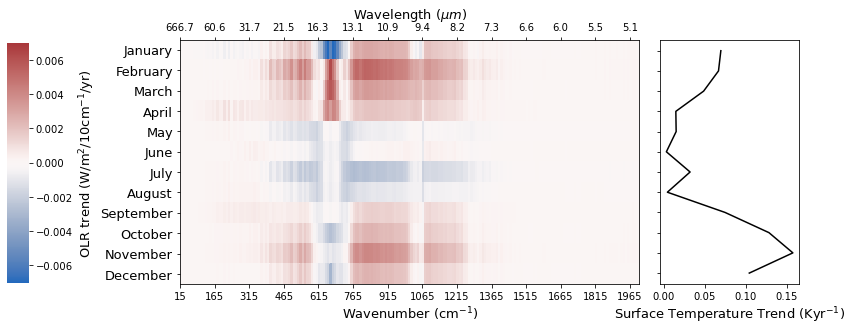

In [160]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_trend_spatavg.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

fig1 = plt.figure(constrained_layout=False,figsize=(20,4.5))
gs1 = fig1.add_gridspec(nrows=3, ncols=4, left=0.05, right=0.48, wspace=0.15,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:, :3])
f1_ax2 = fig1.add_subplot(gs1[:, 3:])

# Plot the average OLR
# olr_trend_spatavg[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
# f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([-0.07, 0.13, 0.015, 0.74])
# cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax1,cbar_ax=cbar_axh2,vmin=-0.007,vmax=0.007)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)


f1_ax2.plot(gisstemp_AIRStrends_spatavg,gisstemp_AIRStrends_spatavg.month,color='black')

# f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function1(X):
    return ["%.0f" % z for z in X]

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1.set_xticks(tick_indices)
f1_ax1b.set_xticks(tick_indices)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
f1_ax1b.set_xticklabels(tick_function2(tick_values))

f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=13)
f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=13) # W/m$^{2}$/10cm$^{-1}$

f1_ax1.set_yticklabels(f1_ax1.get_yticklabels(),fontdict={'fontsize':13})

f1_ax2.set_xlabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13)
f1_ax2.set_yticks(np.arange(1,12.1,1))
noout = f1_ax2.set_yticklabels(12*[None])

In [162]:
to_png(fig1,"spectraltrends_withtemp",bbox_inches="tight")

Text(0.5, 33.0, 'Surface Temperature Trend (Kyr$^{-1}$)')

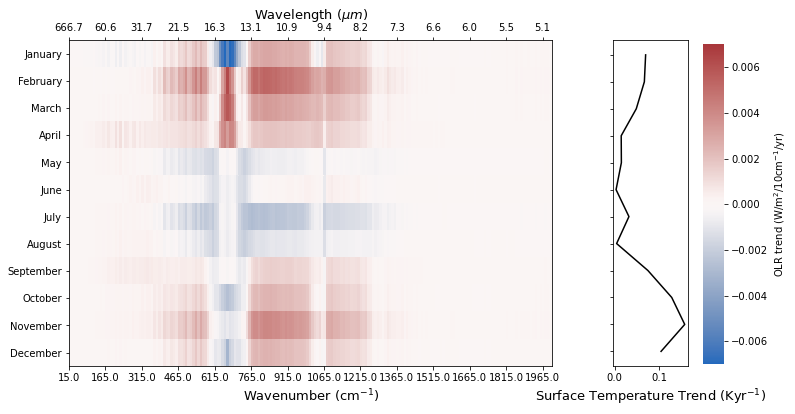

In [137]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_trend_spatavg.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

fig1 = plt.figure(constrained_layout=False,figsize=(20,6))
gs1 = fig1.add_gridspec(nrows=3, ncols=5, left=0.05, right=0.48, wspace=0.8,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:, :4])
f1_ax2 = fig1.add_subplot(gs1[:, 4:])

# Plot the average OLR
# olr_trend_spatavg[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
# f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([0.49, 0.13, 0.015, 0.74])
# cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax1,cbar_ax=cbar_axh2,vmin=-0.007,vmax=0.007)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)')#, rotation=270)


f1_ax2.plot(gisstemp_AIRStrends_spatavg,gisstemp_AIRStrends_spatavg.month,color='black')

# f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function1(X):
    return ["%.1f" % z for z in X]

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax2.set_yticks(np.arange(1,12.1,1))
f1_ax2.set_yticklabels(12*[None])
# f1_ax1b.set_xticks(ax2Ticks)
f1_ax1.set_xticks(tick_indices)
f1_ax1b.set_xticks(tick_indices)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1.set_xticklabels(tick_function1(tick_values))
f1_ax1b.set_xticklabels(tick_function2(tick_values))
# f1_ax1b.set_xticklabels(tick_function(new_labels))
f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=13) # W/m$^{2}$/10cm$^{-1}$
# f1_ax1.set_ylabel('OLR (W/m$^{2}$/10cm$^{-1}$)')
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=13)
f1_ax2.set_xlabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13)

Text(0.5, 371.4378947368421, 'Wavenumber (cm$^{-1}$)')

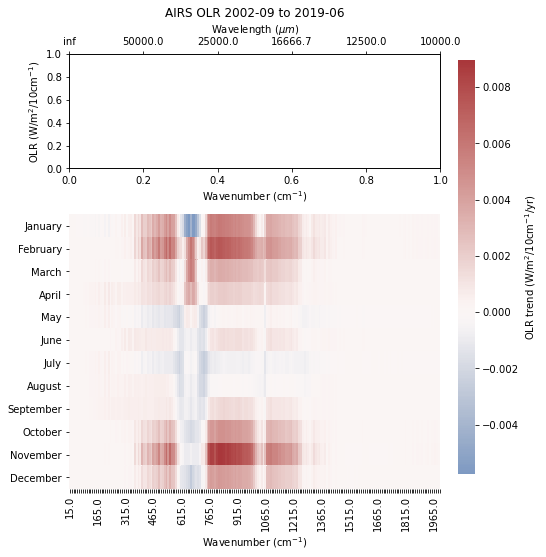

In [37]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_clr_trend_spatavg.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

fig1 = plt.figure(constrained_layout=False,figsize=(12,8))
gs1 = fig1.add_gridspec(nrows=3, ncols=5, left=0.05, right=0.48, wspace=0.05,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:1, :])
f1_ax2 = fig1.add_subplot(gs1[-2:, :])

# Plot the average OLR
# olr_trend_spatavg[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_clr_trend_spatavg, center=0, cmap='vlag', 
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax2,cbar_ax = cbar_axh2)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)')#, rotation=270)

f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))
f1_ax1b.set_xlabel('Wavelength ($\mu m$)') # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('OLR (W/m$^{2}$/10cm$^{-1}$)')
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)')